In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from gensim.models import Word2Vec
from scapy.all import PcapReader
from sklearn.feature_selection import f_classif, SelectKBest, RFE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
)

from read_pcaps import pcap_to_dataframe

2024-04-02 20:39:17.619273: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 20:39:17.679262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 20:39:17.679321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 20:39:17.681791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 20:39:17.692483: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 20:39:19.287263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [2]:
# define a variable that allows you to read prior saved pkl files
READ_FROM_PKL = True

In [3]:
if READ_FROM_PKL:
    mirai_df = pd.read_pickle("../data/blog_eda/mirai.pkl")
    benign_df = pd.read_pickle("../data/blog_eda/benign.pkl")
else:
    pcap_reader_mirai = PcapReader("../data/blog_eda/mirai.pcap")
    pcap_reader_benign = PcapReader("../data/blog_eda/benign.pcapng")
    mirai_df = pcap_to_dataframe(pcap_reader_mirai)
    benign_df = pcap_to_dataframe(pcap_reader_benign)

In [4]:
# read features saved, add new ones
if READ_FROM_PKL:
    mirai_features_df = pd.read_pickle("../data/blog_fe/mirai_features.pkl")
    benign_features_df = pd.read_pickle("../data/blog_fe/benign_features.pkl")
else:
    print(
        "Error! Feature pkl not saved. Please run blog_fe_2.ipynb, blog_fe_3.ipynb, blog_fe_4.ipynb or download from here: https://drive.google.com/drive/folders/1dBQhbQtIk_fbbb80G5pSVV3hbWYJY7fv?usp=sharing"
    )

In [5]:
# drop rows with None
mirai_df = mirai_df.dropna()
benign_df = benign_df.dropna()

# Add labels

In [6]:
# add labels, 0 for benign, 1 for malicious
mirai_features_df["Label"] = 1
benign_features_df["Label"] = 0

In [7]:
concatenated_df = pd.concat([mirai_features_df, benign_features_df], ignore_index=True)

In [8]:
shuffled_df = shuffle(concatenated_df, random_state=42)

In [9]:
# make sure that all features are numeric, otherwise feature selection will not work
shuffled_df.columns

Index(['Timestamp', 'Source Port', 'Destination Port', 'Packet Length',
       'Protocol', 'incoming_traffic', 'outgoing_traffic', 'traffic_ratio',
       'cumulative_length', 'interarrival', 'log_interarrival',
       'Numeric Source IP', 'Numeric Destination IP', 'payload_proto_encoded',
       'ICMP', 'TCP', 'UDP', 'Telnet', 'IPv6_encapsulation', 'GRE', 'ESP',
       'AH', 'DNS', 'ICMPv6', 'OSPF', 'SCTP', 'UDPLite', 'NETBIOS-NS',
       'NETBIOS-DGM', 'NETBIOS-SSN', 'IMAP', 'SNMP', 'SNMP_trap', 'HTTPS',
       'Syslog', 'LDAPS', 'FTPS', 'IMAPS', 'POP3S', 'SOCKS_proxy',
       'length_risk', 'dst_port_freq_encoded', 'payload_embedding', 'Label'],
      dtype='object')

In [10]:
shuffled_df = shuffled_df.drop("payload_embedding", axis=1)
shuffled_df_values = shuffled_df.values.astype(np.float64)

# Find rows with infinite values
inf_rows = np.isinf(shuffled_df_values).any(axis=1)

# Remove rows with infinite values
shuffled_df = shuffled_df[~inf_rows]

In [11]:
# Find rows with infinite values
inf_rows = shuffled_df.index[np.isinf(shuffled_df).any(1)]

# Remove rows with infinite values
shuffled_df = shuffled_df.drop(inf_rows)

# Display the DataFrame after removing rows with infinite values
print("\nDataFrame after removing rows with infinite values:")
print(shuffled_df)


DataFrame after removing rows with infinite values:
           Timestamp  Source Port  Destination Port  Packet Length  Protocol  \
104819  1.540452e+09      33489.0              53.0           41.0      17.0   
171876           NaN          NaN               NaN            NaN       NaN   
50181   1.540449e+09       4259.0              53.0           38.0      17.0   
144342  1.540453e+09      21897.0              23.0           26.0       6.0   
201802           NaN          NaN               NaN            NaN       NaN   
...              ...          ...               ...            ...       ...   
119879  1.540452e+09         23.0           21897.0           26.0       6.0   
103694  1.540452e+09       2148.0              53.0           50.0      17.0   
131932  1.540453e+09      59081.0              53.0           48.0      17.0   
146867  1.540453e+09      21897.0              23.0           26.0       6.0   
121958  1.540452e+09      50861.0           10240.0           48.0 

/tmp/ipykernel_208154/458818108.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  inf_rows = shuffled_df.index[np.isinf(shuffled_df).any(1)]


In [12]:
shuffled_df = shuffled_df.dropna()

# Split data
- Train
- Test

In [13]:
# X should contain your feature columns, and y should contain the labels (0 or 1)
X = shuffled_df.drop(columns=["Label"], axis=1)
y = shuffled_df["Label"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest Classifier

In [14]:
# Train a classifier using the selected features
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Calculate metrics
y_true = shuffled_df["Label"]  # True labels
y_pred = clf.predict(shuffled_df.drop("Label", axis=1))  # Predicted labels

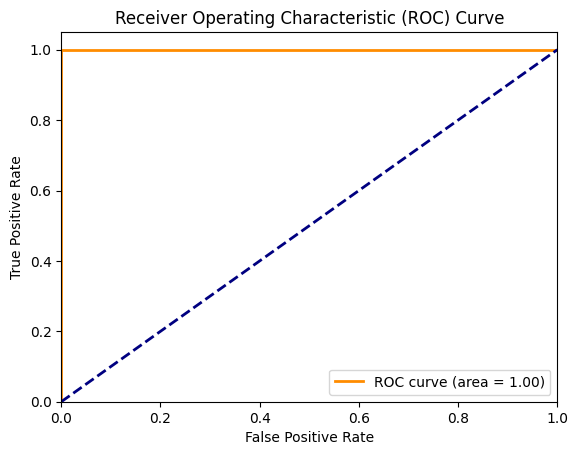

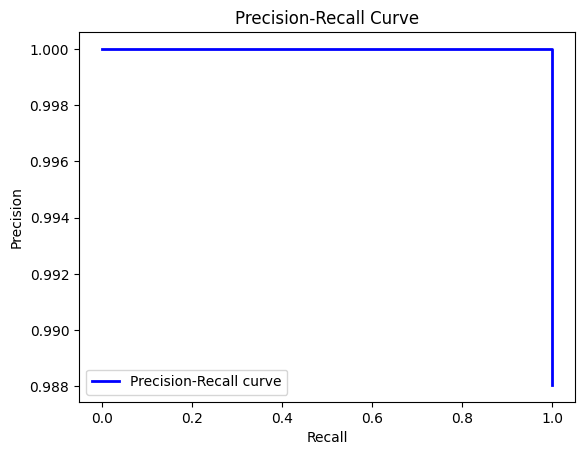

Accuracy: 1.0
Precision: [0.98804805 1.         1.        ]
Recall: [1. 1. 0.]
F1 Score: 1.0


In [16]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


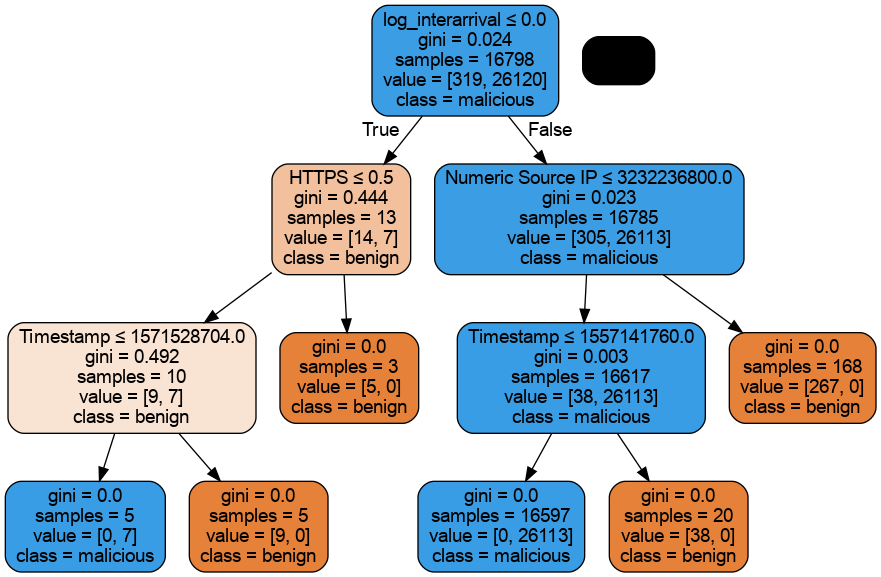

In [17]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

# Assuming model is your trained Random Forest model
# Visualize one of the decision trees (e.g., the first one)
estimator = clf.estimators_[0]

# Export the decision tree to a DOT file
export_graphviz(estimator, out_file="tree.dot", 
                feature_names=shuffled_df.columns[:-1],  # Assuming the last column is the label column
                class_names=["benign", "malicious"],  # Specify class names if applicable
                filled=True, rounded=True, special_characters=True)

# Convert the DOT file to a PNG image
graph = pydotplus.graph_from_dot_file("tree.dot")
graph.write_png("tree.png")

# Display the decision tree
Image("tree.png")


# Decision Tree

In [18]:
# Train a classifier using the selected features
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [19]:
# Calculate metrics
y_true = shuffled_df["Label"]  # True labels
y_pred = clf.predict(shuffled_df.drop("Label", axis=1))  # Predicted labels

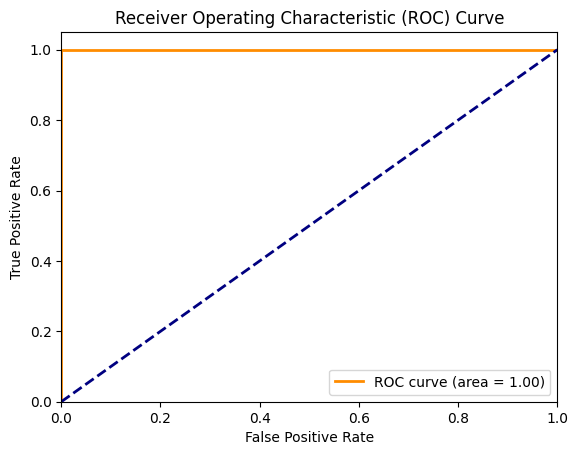

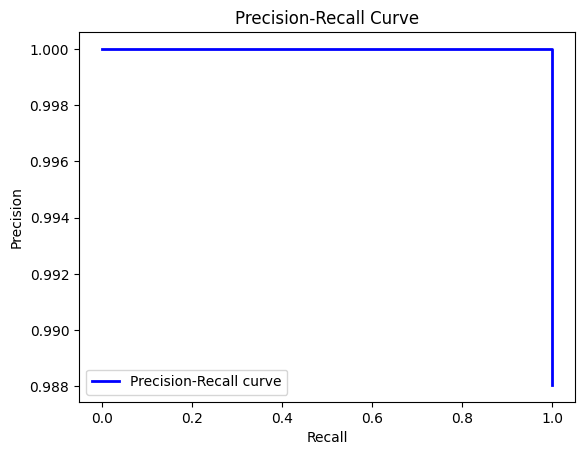

Accuracy: 1.0
Precision: [0.98804805 1.         1.        ]
Recall: [1. 1. 0.]
F1 Score: 1.0


In [20]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [22]:
import dtreeviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with features and labels
# Split the data into features and labels
X = shuffled_df.drop("Label", axis=1)
y = shuffled_df["Label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Instantiate a decision tree classifier
model = DecisionTreeClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Visualize the decision tree
viz_model = dtreeviz.model(
    model,
    X_train,
    y_train,
    target_name="Label",
    feature_names=list(shuffled_df.columns[:-1]),  # Assuming the last column is the label column
    class_names=["benign", "malicious"],
)  # Specify class names if applicable

# Display the visualization
v = viz_model.view()  # render as SVG into internal object
v.show()  # pop up window
v.save("/tmp/mirai.svg")  # optionally save as svg

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f